In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()

print(most_recent_date)


2017-08-23


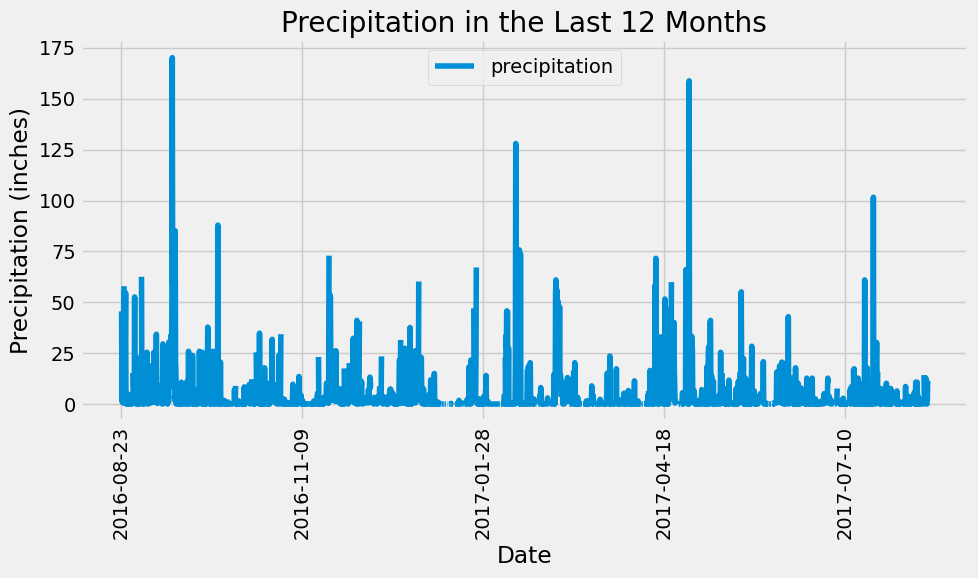

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='precipitation', figsize=(10, 6), rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in the Last 12 Months")
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [16]:
summary_stats = df['precipitation'].describe()
print(summary_stats)


count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number of stations in the dataset
# Query to calculate the total number of stations
total_stations = session.query(Station).count()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")

print("-----------------------------------")

most_active_station = active_stations[0][0]
print(f"The station with the greatest number of observations: {most_active_station}")

print("-----------------------------------")

temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
avg_temp = temperature_stats[0][2]

print(f"Temperature Statistics for Station {most_active_station}:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Most Active Stations:
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511
-----------------------------------
The station with the greatest number of observations: USC00519281
-----------------------------------
Temperature Statistics for Station USC00519281:
Lowest Temperature: 12.2°F
Highest Temperature: 29.4°F
Average Temperature: 22.04°F


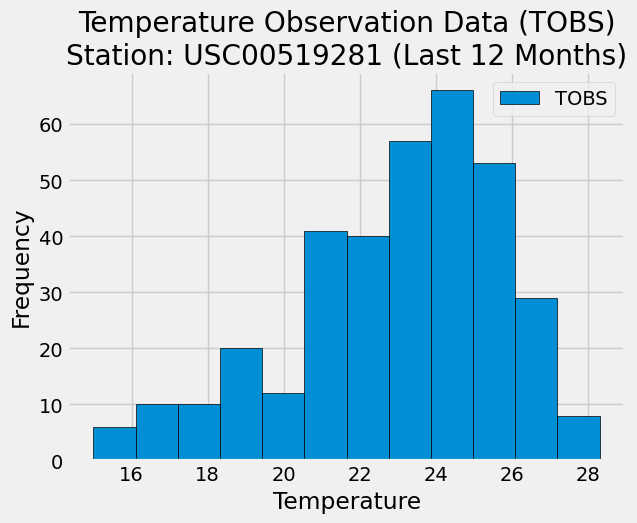

In [40]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= prev_year).all()
tobs_values = [result[1] for result in tobs_data]

plt.hist(tobs_values, bins=12, edgecolor='black', label='TOBS')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data (TOBS)\nStation: USC00519281 (Last 12 Months)')

plt.show()

# Close Session

In [41]:
# Close Session
session.close()